## Introduction

Association Rule Learning (or Associate Rule Mining) is a rule-based machine learning method to discover how items are associated to each other. Stores use them to figure out products that are bought together, this way they can provide different offers to the different customers e.g, buy one get one free. Earlier, recommendation systems like Amazon, Netflix used them. In this notebook, we will go through Apriori type of Association Rule Learning model.

### Importing libraries and reading the dataset

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

%matplotlib inline

warnings.filterwarnings("ignore")

In [7]:
# load the groceries-dataset
groceries = pd.read_csv("../../data/Groceries_dataset.csv", parse_dates=['Date'])
groceries.shape

(38765, 3)

### Overview

In [8]:
# let's take a peek of dataset
groceries.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


**Dataset Description**

* <b>Member_number:</b> A unique id of each customer who bought groceries
* <b>Date:</b> The date at which the customer bought the groceries
* <b>itemDescription:</b> Description of the item that customer bought

### Exploratory Data Analysis
In EDA, we will first start with individual feature analysis then we will explore multiple feature interactions.<br><br>
**Let's look at the time duration of the data we have given.**

In [9]:
print("We have the data from",groceries.Date.min(),"to", groceries.Date.max())

We have the data from 2014-01-01 00:00:00 to 2015-12-30 00:00:00


In [10]:
# For extracting year,month and day to new column,follow the code:
groceries['year'] = groceries['Date'].dt.year
groceries['month'] = groceries['Date'].dt.month
groceries['day'] = groceries['Date'].dt.day
groceries['day_of_week'] = groceries['Date'].dt.day_name()
groceries.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,Tuesday
1,2552,2015-01-05,whole milk,2015,1,5,Monday
2,2300,2015-09-19,pip fruit,2015,9,19,Saturday
3,1187,2015-12-12,other vegetables,2015,12,12,Saturday
4,3037,2015-02-01,whole milk,2015,2,1,Sunday


**Individual Feature Visualisation**<br><br>
We start by simply plotting the distributions of the each feature individually, before moving on to multi-feature visuals and correlations. Here, we’re dealing with the features one by one.<br><br>

Let's look at the customers' visiting rate.

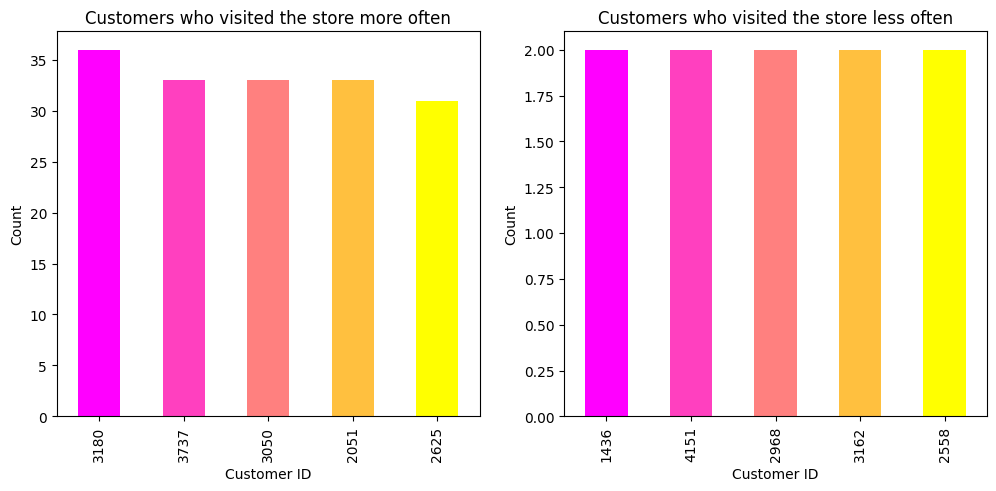

In [14]:
plt.rcParams["figure.figsize"] = [12, 5]

color = plt.cm.spring(np.linspace(0, 1, 5))

fig, (ax, ax2) = plt.subplots(ncols=2)

groceries['Member_number'].value_counts().head().plot(kind='bar', color = color, ax=ax, title='Customers who visited the store more often');
ax.set_xlabel("Customer ID")
ax.set_ylabel("Count")
groceries['Member_number'].value_counts(ascending=True).head().plot(kind='bar', color = color, ax=ax2, title='Customers who visited the store less often');
ax2.set_xlabel("Customer ID")
ax2.set_ylabel("Count");

We found that:

* Member number 3180 bought the highest number of groceries, followed by Member number 3050, 2051 and 3737.
* A lot of customers visited the store twice (seem to be tourists).<br><br>
Let's look at the date at which customers visited the store.

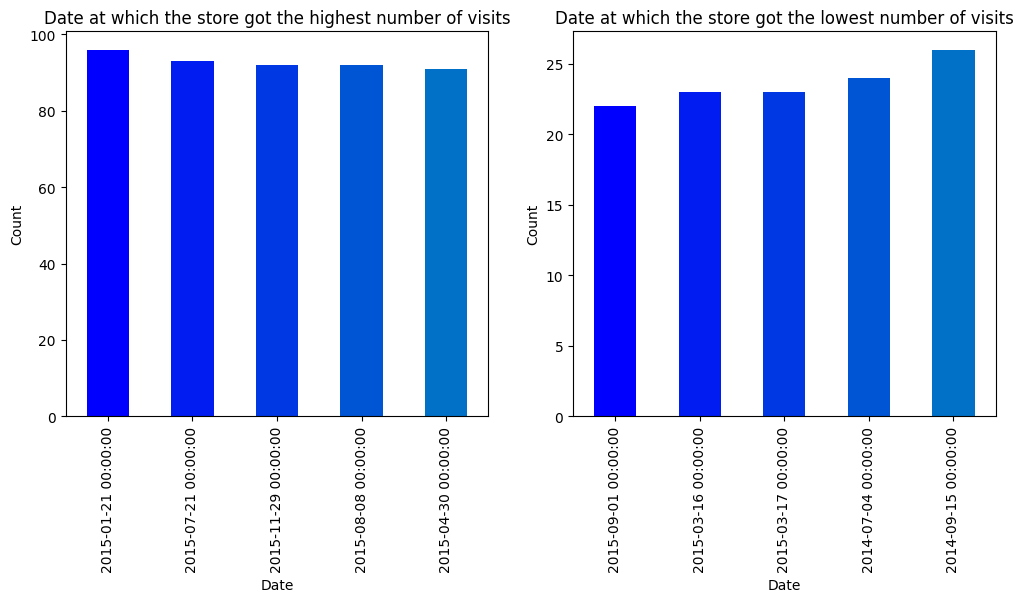

In [16]:
plt.rcParams["figure.figsize"] = [12, 5]

color = plt.cm.winter(np.linspace(0, 1, 10))

fig, (ax, ax2) = plt.subplots(ncols=2)

groceries['Date'].value_counts().head().plot(kind='bar', color = color, ax=ax, title='Date at which the store got the highest number of visits');
ax.set_xlabel("Date")
ax.set_ylabel("Count")
groceries['Date'].value_counts(ascending=True).head().plot(kind='bar', color = color, ax=ax2, title='Date at which the store got the lowest number of visits');
ax2.set_xlabel("Date")
ax2.set_ylabel("Count");

We found that:

* A large number of customers visited the store on 21st January 2015 followed by 21st July 2015
* Few customers visited the store on 9th January 2015 followed by 16th March 2015
* Both the highest most visitors and least visitors are recorded in 2015<br><br>
Let's look at the total count of items bought

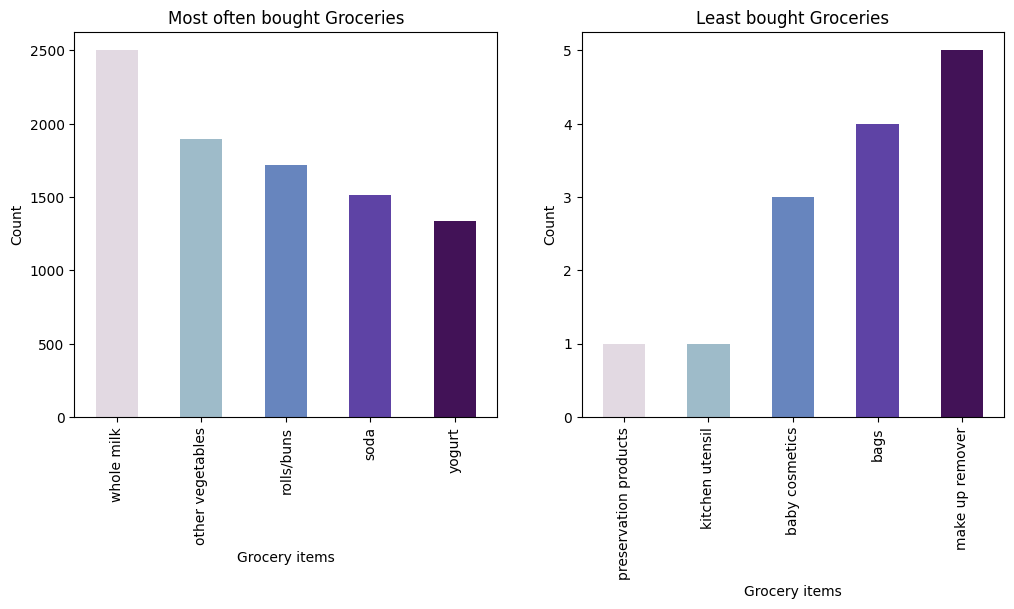

In [19]:
plt.rcParams["figure.figsize"] = [12, 5]
color = plt.cm.twilight(np.linspace(0, 1, 10))

fig, (ax, ax2) = plt.subplots(ncols=2)

groceries['itemDescription'].value_counts().head().plot(kind='bar', color = color, ax=ax, title='Most often bought Groceries');
ax.set_xlabel("Grocery items")
ax.set_ylabel("Count")
groceries['itemDescription'].value_counts(ascending=True).head().plot(kind='bar', color = color, ax=ax2, title='Least bought Groceries');
ax2.set_xlabel("Grocery items")
ax2.set_ylabel("Count");

We found:

* Whole milk is the highest bought item followed by other vegetables and rolls/buns
* Preservation products and kitchen utensils are the least bought.<br><br>
Let's look at the day of the month at which customers visited the store.

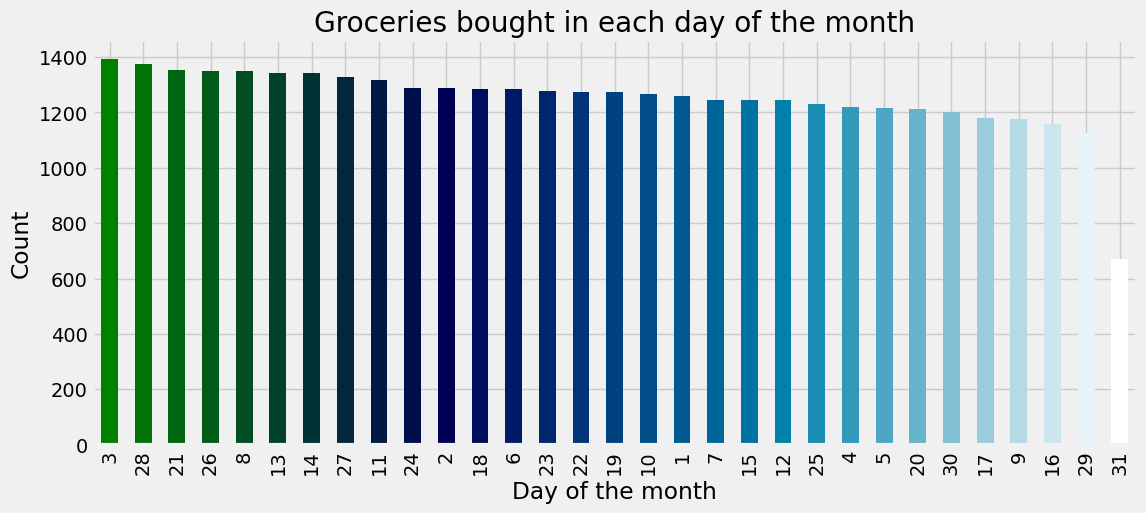

In [20]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [12, 5]
color = plt.cm.ocean(np.linspace(0, 1, 31))

groceries['day'].value_counts().plot(kind='bar', color=color, title='Groceries bought in each day of the month').set(xlabel='Day of the month', ylabel='Count');

We found that:

* 28th is the day of the month where highest amount of items are bought
* 31st is the day of the month where lowest amount of items are bought (maybe because at the end of the month people were short on budget.)<br><br>
Let's look at the groceries bought in each month.

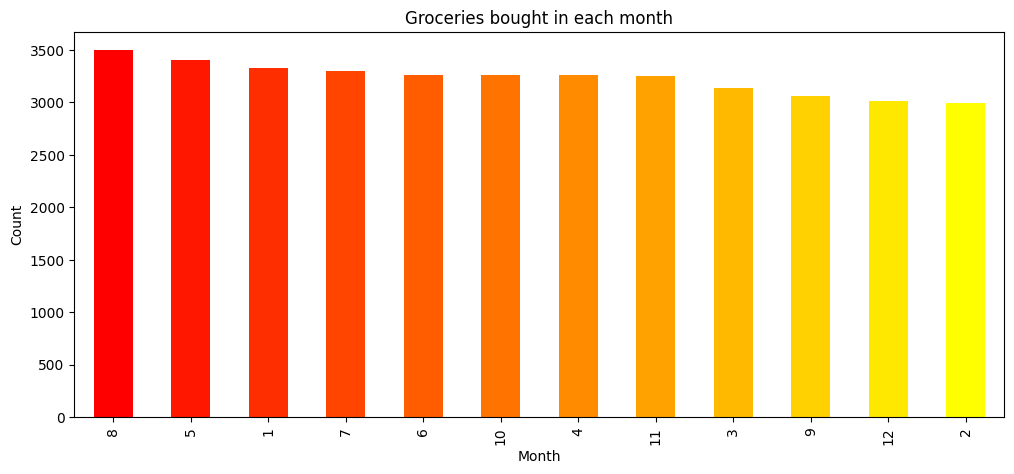

In [21]:
plt.rcdefaults()
plt.rcParams["figure.figsize"] = [12, 5]
color = plt.cm.autumn(np.linspace(0, 1, 12))

groceries['month'].value_counts().plot(kind='bar', color=color, title='Groceries bought in each month').set(xlabel='Month', ylabel='Count');

We found that:

* In August, the highest amount of items are purchased.
* In September, the lowest amount of items are purchased.<br><br>
Let's look at the groceries bought in each Year.

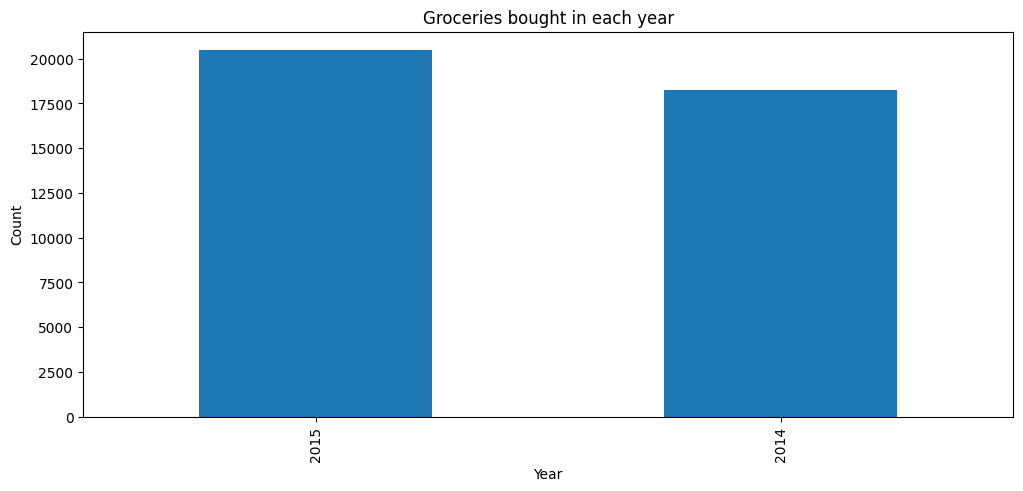

In [23]:
plt.rcdefaults()
plt.rcParams["figure.figsize"] = [12, 5]

groceries['year'].value_counts().plot(kind='bar', title='Groceries bought in each year').set(xlabel='Year', ylabel='Count');

We found that:

* In 2015, highest number of customers visited the store.
* Both 2015 and 2014 are really close in terms of customer visiting rate.<br><br>
Let's look at groceries bought in each day of the week.

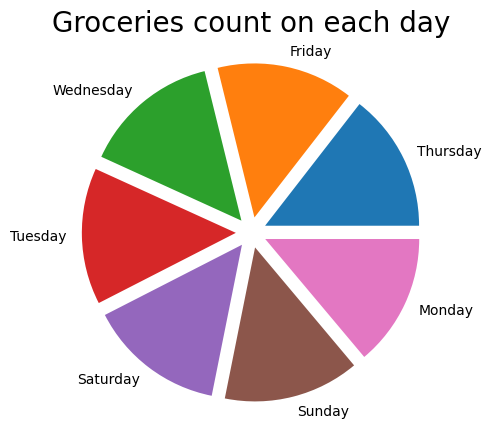

In [25]:
groceries['day_of_week'].value_counts().head(15).plot.pie(figsize = (12, 5), explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))

plt.title('Groceries count on each day',fontsize = 20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 90)
plt.show()

We found that:

* The Customer Visiting Rate is equally distributed across all the days of week.

**Multiple Feature Interactions Visualisation**<br><br>
We started with looking at each individual feature, let's start looking at feature relations, we will first go through time series analysis to manipulate and visualize time series data. To make it easier, we will aggregate customer's data and items data into single dataframe with respect to time.

In [27]:
# let's aggregate the data with date to see more clearly which items are bought on which date
# create a new dataframe and store unique visitors and unique bought items
groceries_time = pd.DataFrame(groceries.groupby('Date')['itemDescription'].nunique().index)
groceries_time['members_count'] = groceries.groupby('Date')['Member_number'].nunique().values
groceries_time['items_count'] = groceries.groupby('Date')['itemDescription'].nunique().values
groceries_time['items'] = groceries.groupby('Date')['itemDescription'].unique().values
groceries_time.set_index('Date',inplace=True)
groceries_time.head()

,members_count,items_count,items
Date,,,
2014-01-01,21,30,"[cleaner, sausage, tropical fruit, whole milk,..."
2014-01-02,25,37,"[beef, frankfurter, hamburger meat, soda, UHT-..."
2014-01-03,21,34,"[frankfurter, oil, beef, long life bakery prod..."
2014-01-04,17,31,"[ham, chocolate, instant coffee, specialty cho..."
2014-01-05,24,43,"[meat, hamburger meat, sausage, liver loaf, tr..."


Summarizing the data with Density plots to see where the mass of the data is located

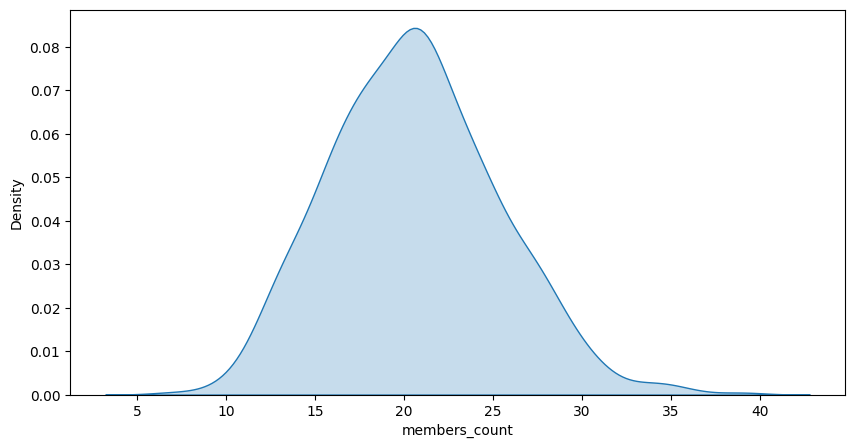

In [31]:
plt.rcParams["figure.figsize"] = [10, 5]

sns.kdeplot(data = groceries_time['members_count'],shade=True);

It's seems like data is uniformly distributed without any trend. Let's verify that using lineplots.

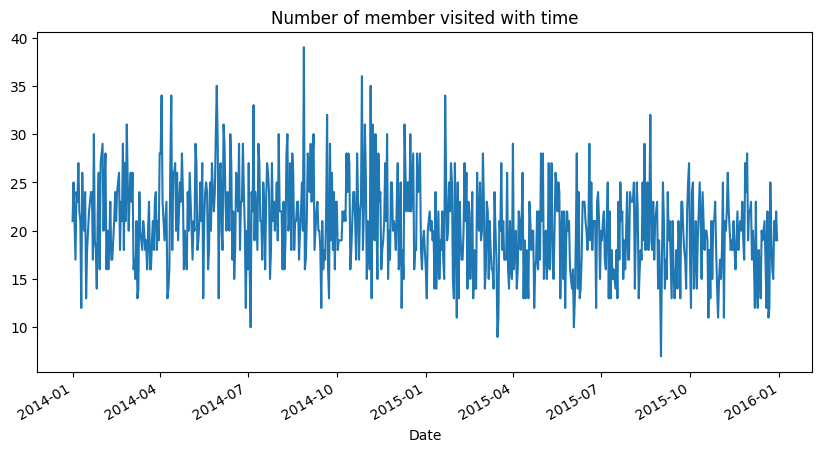

In [32]:
groceries_time['members_count'].plot(figsize=(10, 5),title='Number of member visited with time');

It appears that store had a more or less steady increase in its stock price over the from January 2014 to the January 2016 window. Therefore, we will now use association rules to find pairs of items that are associated to each other.

### Associate Rule Learning
Association rule learning is a technique to discover how items are associated to each other. Association can be measured in three common ways.

**Support**<br><br>
It tell us about how popular an itemset is, as measured by the proportion of transactions in which an itemset appears. It is measured as follows:

For Movie Recommendation, we calculate it as:
$$support(M)=\frac{number\ of\ user\ watchlists\ containing\ M}{total\ number\ of\ user\ watchlists}$$
wheras for Market Basket Optimization, we calculate it as:
$$support(I)=\frac{number\ of\ transactions\ containing\ I}{total\ number\ of\ transactions}$$

**Confidence**<br><br>
It tell us about how likely item B is purchased when item A is purchased, expressed as {A -> B}. It is measured as follows:

For Movie Recommendation, we calculate it as:
$$confidence(M1→M2)=\frac{number\ of\ user\ watchlists\ containing\ M1\ and\ M2}{number\ of\ user\ watchlists\ containing\ M1}$$
wheras for Market Basket Optimization, we calculate it as:
$$confidence(I1→I2)=\frac{number\ of\ transactions\ containing\ I1\ and\ I2}{number\ of\ transactions\ containing\ I1}$$

**Lift**<br><br>
It tell us about how likely the item B is purchased when the item A is purchased while controlling for how popular item B is. It is measured as follows:

For Movie Recommendation, we calculate it as:
$$lift(M1→M2)=\frac{Confidence(M1→M2)}{Support(M2)}$$
wheras for Market Basket Optimization, we calculate it as:
$$lift(I1→I2)=\frac{Confidence(I1→I2)}{Support(I2)}

### Apriori Algorithm

Apriori algorithm consist of:

1. Step 1: Set a minimum support and confidence.
2. Step 2: Take all the subsets in transactions having higher support than minimum support.
3. Step 3: Take all the rules of these subsets having higher confidence than minimum confidence.
4. Step 4: Sort the rules by decreasing lift.<br><br>
We will be using apriori function from apyori package to implement the apriori algorithm. It return all the different association measures (or the rules) such support, confidence and lift.

In [33]:
from apyori import apriori

In [34]:
transactions = groceries_time['items'].tolist()

In [38]:
# Let's run the algorithm and transform the result into well organised pandas dataframe to see which item 
# pairs are associated more or less.

rules = apriori(transactions = transactions, min_support=0.00030, min_confidance=0.01, min_lift=3, min_length=2, max_length=2)
#let's transform them into a list
results = list(rules)

def inspect(results):
    '''
    function to put the result in well organised pandas dataframe
    '''
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))

resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Item #1', 'Item #2', 'Support', 'Confidence', 'Lift'])
resultsinDataFrame.head()

,Item #1,Item #2,Support,Confidence,Lift
0,Instant food products,baby cosmetics,0.002747,0.035088,8.514620
1,Instant food products,bags,0.001374,0.017544,3.192982
2,Instant food products,liqueur,0.004121,0.052632,4.257310
3,abrasive cleaner,cleaner,0.005495,0.181818,4.564263
4,artif. sweetener,baby cosmetics,0.001374,0.035714,8.666667


In [40]:
# Let's sort all the rules by decreasing lift.
resultsinDataFrame.nlargest(n=10, columns='Lift')

,Item #1,Item #2,Support,Confidence,Lift
169,liqueur,preservation products,0.001374,0.111111,80.888889
160,kitchen utensil,prosecco,0.001374,1.000000,38.315789
157,kitchen utensil,male cosmetics,0.001374,1.000000,20.800000
203,preservation products,spices,0.001374,1.000000,18.666667
21,bags,frozen fruits,0.001374,0.250000,16.545455
201,preservation products,soups,0.001374,1.000000,15.826087
118,frozen chicken,organic products,0.001374,0.200000,14.560000
92,decalcifier,salad dressing,0.001374,0.111111,13.481481
113,frozen chicken,frozen fruits,0.001374,0.200000,13.236364
81,cream,frozen chicken,0.001374,0.083333,12.133333


<b>In the store, people bought liquer with preservation products, kitchen utensil with prosecco and preservation products with spices. The store should add deals with preservation products, kitchen utensil and frozen chicken to increase it sales.</b>